In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt, exp

from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
def display(arr, dim_x=28, dim_y=28):
    plt.imshow(arr.reshape((dim_x, dim_y)), cmap="Greys")

In [3]:
mat = loadmat('mnist_all.mat')

In [10]:
train_size = 50_000
valid_size = 10_000
test_size  = 10_000

feature_size = 784

train_valid_data = np.empty((0, feature_size))
train_valid_label = np.empty((0, 1))

train_data = np.empty((0, feature_size))
train_label = np.empty((0, 1))

valid_data = np.empty((0, feature_size))
valid_label = np.empty((0, 1))

test_data = np.empty((0, feature_size))
test_label = np.empty((0, 1))

for key in mat:
    if key.startswith('train'):
        labels = np.ones(mat[key].shape[0]) * int(key[-1])
        train_valid_data = np.vstack([train_valid_data, mat[key]])
        train_valid_label = np.vstack([train_valid_label, labels.reshape(mat[key].shape[0], 1)])
    elif key.startswith('test'):
        labels = np.ones(mat[key].shape[0]) * int(key[-1])
        test_data = np.vstack([test_data, mat[key]])
        test_label = np.vstack([test_label, labels.reshape(mat[key].shape[0], 1)])

idxs = np.random.permutation(train_size + valid_size)

train_data = train_valid_data[idxs[:train_size], :]
train_label = train_valid_label[idxs[:train_size]]

valid_data = train_valid_data[idxs[train_size:], :]
valid_label = train_valid_label[idxs[train_size:]]

(None, array([6.]))

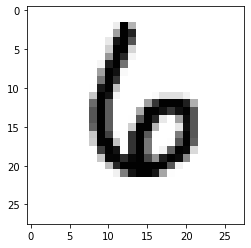

In [6]:
i = 45000
display(train_data[i]), train_label[i]

(None, array([4.]))

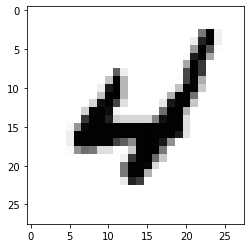

In [7]:
i = 6500
display(valid_data[i]), valid_label[i]

(None, array([4.]))

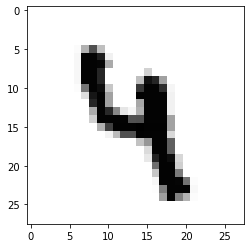

In [8]:
i = 4500
display(test_data[i]), test_label[i]

In [9]:
idx_to_del = []
for i in range(feature_size):
    if train_data[:, i].min() == train_data[:, i].max() and valid_data[:, i].min() == valid_data[:, i].max():
        idx_to_del.append(i)
        
train_data = np.delete(train_data, idx_to_del, axis=1)